# Consigna TP2

<b> Parte 1 </b> <br>
Implementar la función create_gauss_filter (h, w, k_size , para crear filtros gaussianos para filtrado
espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.
<ol>
    <li>Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para
validar el funcionamiento en el dominio espectral. </li>
    <li>Usando el método descripto en el paper Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral. </li>
    <li>Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape from focus” </li>
</ol>




# Parte 1: Filtro graussiano

In [2]:
#Si queremos que las imágenes sean mostradas en una ventana emergente descomentar el inline
# %matplotlib

import numpy as np  # OpenCV-Python utiliza NumPy para el manejo de imágenes
import cv2 as cv    # cv2 es el módulo python para acceder a OpenCV 
import matplotlib.pyplot as plt # Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc

from mpl_toolkits.axes_grid1 import ImageGrid

# Parte 1

## Cargo imagenes

In [4]:
from scipy import signal 

def create_gaussian_filter(h, w, k_size, sigma, plot, verbose=False):
    assert k_size%2, 'Error. Kernel size k_size should be odd'
    assert k_size<=h and k_size<=w, 'Error. Kernel size k_size should be smaller than image dimensions'

    ker_x = cv.getGaussianKernel(ksize=k_size, sigma=sigma) 
    ker_y = cv.getGaussianKernel(ksize=k_size, sigma=sigma)
    kernel = signal.convolve2d(ker_y, ker_x.transpose(), mode='full')
    
    # Agrando kernel al tamaño de la imagen con zero padding
    pad_x = int(np.floor((w-k_size)/2))
    pad_x = (pad_x, w-(k_size+pad_x))
    pad_y = int(np.floor((h-k_size)/2))
    pad_y = (pad_y, h-(k_size+pad_y))
    ker_spacial = np.pad(kernel, (pad_y, pad_x), 'constant')

    if(verbose):
        print('Pad x: ' + str(pad_x))
        print('Pad y: ' + str(pad_y))
        print('Kernel shape: ' + str(ker_spacial.shape))
        print(ker_spacial)
    assert ker_spacial.shape == (h,w), 'Error in code. Resulting kernel doesnt match image size'
    
    ker_spectral = np.fft.fft2(ker_spacial)
    if(plot):
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(ker_spacial, cmap='jet')
        plt.subplot(1,2,2)
        plt.imshow(20*np.log(np.abs(ker_spectral)), cmap='jet')


    return ker_spacial, ker_spectral

def filter_spectral(img, kernel_spectral):
    img_fft = np.fft.fft2(img)
    result = img_fft * kernel_spectral
    return np.real(np.fft.ifftshift(np.fft.ifft2(result)) )

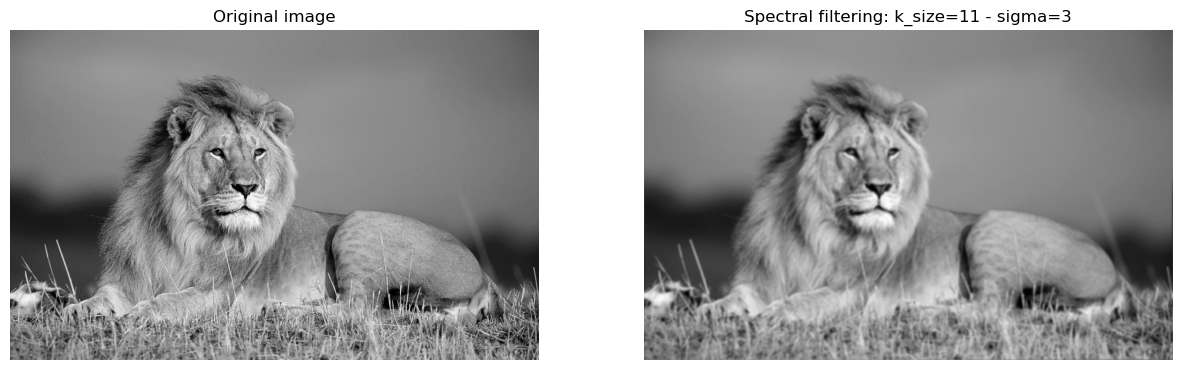

In [6]:

img = cv.imread('./lion2.png', cv.IMREAD_GRAYSCALE)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.title(f'Original image')
plt.imshow(img, cmap='gray')

ker_size = 11
ker_sigma = 3
fil_spacial, fil_spectral = create_gaussian_filter(h=img.shape[0], w=img.shape[1], k_size=ker_size, sigma=ker_sigma, plot=False)
img_filtered = filter_spectral(img, fil_spectral)
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img_filtered, cmap='gray')
a=plt.title(f'Spectral filtering: k_size={ker_size} - sigma={ker_sigma}')



# Punto 2

Text(0.5, 1.0, 'Filtered spectral - FM=0.002206875')

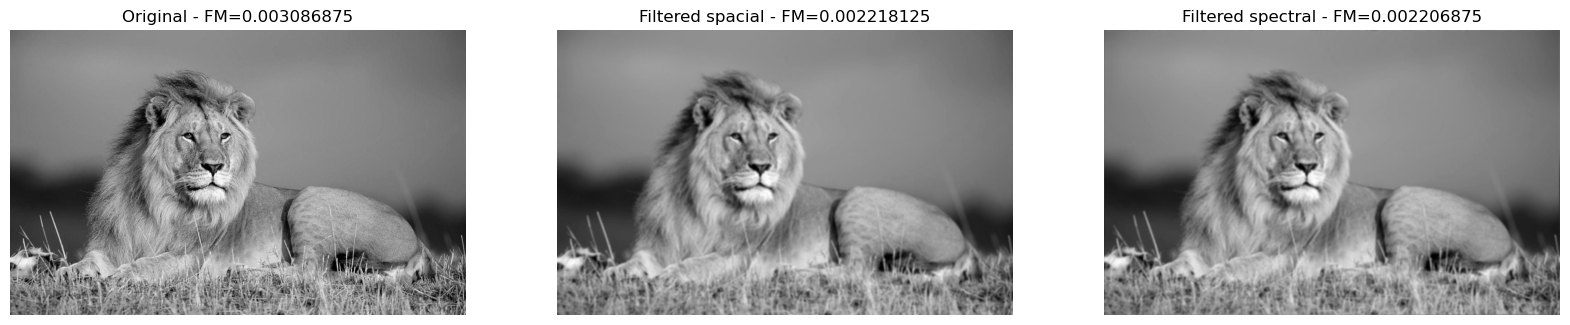

In [19]:
def metric_fm(img):
    Fc = np.fft.fftshift(np.fft.fft2(img))
    AF = np.abs(Fc)
    M = np.max(AF)
    Th = AF[AF > M / 1000].size
    return Th / img.size

# Filter image using spectral and spacial filtering
img = cv.imread('./lion2.png', cv.IMREAD_GRAYSCALE)
ker_size = 11
ker_sigma = 3
fil_spacial, fil_spectral = create_gaussian_filter(h=img.shape[0], w=img.shape[1], k_size=ker_size, sigma=ker_sigma, plot=False)
filtered_spectral = filter_spectral(img, fil_spectral)
filtered_spacial = cv.filter2D(src=img, ddepth=-1, kernel=fil_spacial)

plt.figure(figsize=(20,13))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f'Original - FM={metric_fm(img)}')
plt.subplot(1,3,2)
plt.imshow(filtered_spacial, cmap='gray')
plt.axis('off')
plt.title(f'Filtered spacial - FM={metric_fm(filtered_spacial)}')
plt.subplot(1,3,3)
plt.imshow(filtered_spectral, cmap='gray')
plt.axis('off')
plt.title(f'Filtered spectral - FM={metric_fm(filtered_spectral)}')
    



# Punto 3

Text(0.5, 1.0, 'Filtered spectral - LAP2=0.6304455381917878')

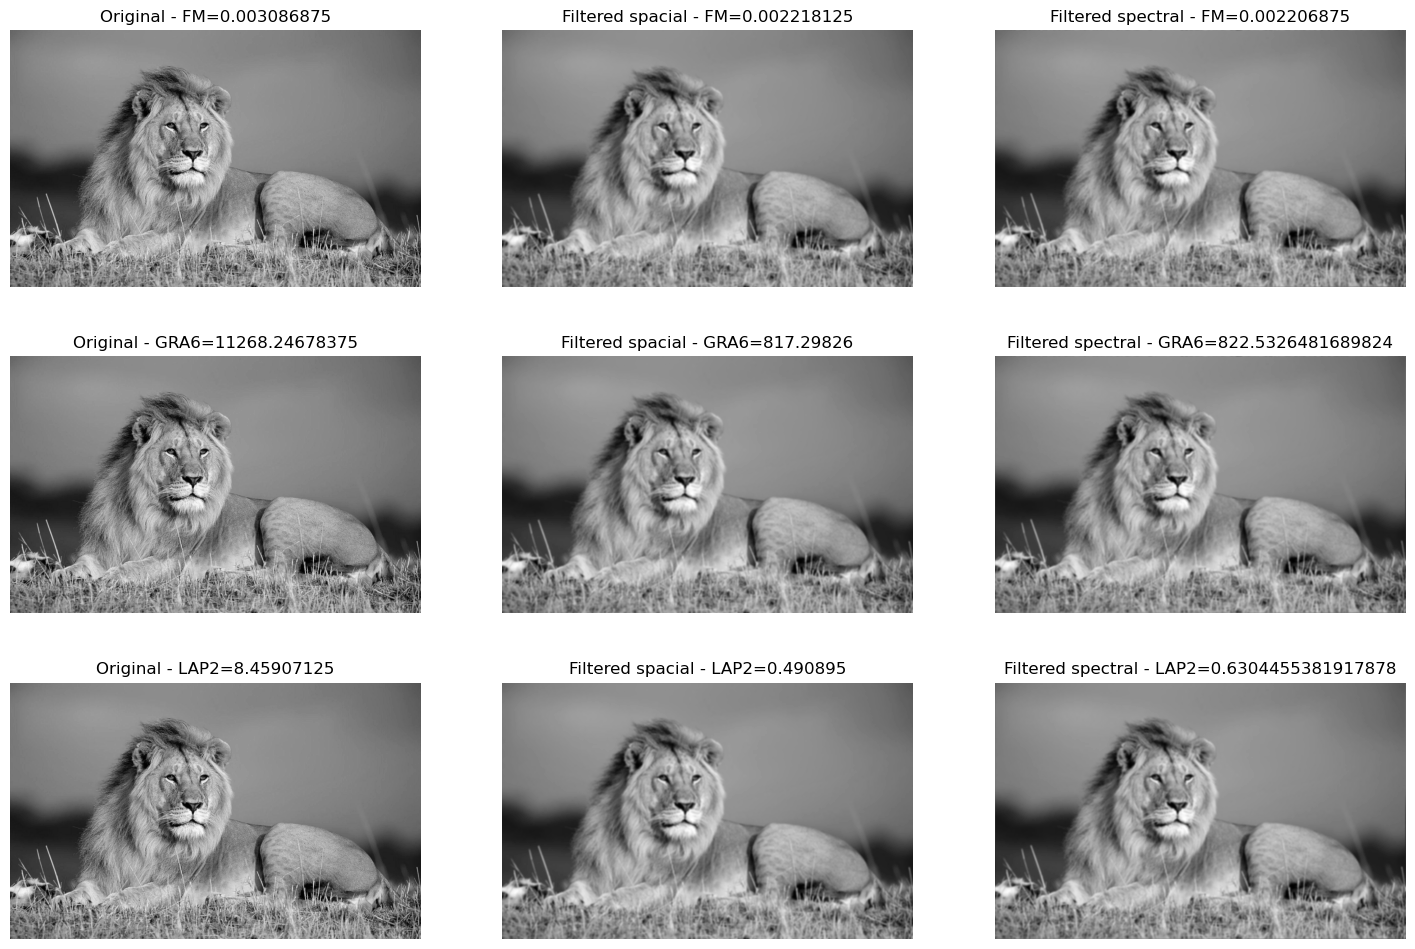

In [28]:
def metric_GRA6(img):
    gaussianX = cv.Sobel(img, cv.CV_64F, 1, 0)
    gaussianY = cv.Sobel(img, cv.CV_64F, 1, 0)
    return np.mean(gaussianX * gaussianX + gaussianY * gaussianY)

def metric_LAP2(img):
    kernel = np.array([-1, 2, -1])
    laplacianX = np.abs(cv.filter2D(img, -1, kernel))
    laplacianY = np.abs(cv.filter2D(img, -1, kernel.T))
    return np.mean(laplacianX + laplacianY)


plt.figure(figsize=(18,12))

plt.subplot(3,3,1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f'Original - FM={metric_fm(img)}')
plt.subplot(3,3,2)
plt.imshow(filtered_spacial, cmap='gray')
plt.axis('off')
plt.title(f'Filtered spacial - FM={metric_fm(filtered_spacial)}')
plt.subplot(3,3,3)
plt.imshow(filtered_spectral, cmap='gray')
plt.axis('off')
plt.title(f'Filtered spectral - FM={metric_fm(filtered_spectral)}')

plt.subplot(3,3,4)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f'Original - GRA6={metric_GRA6(img)}')
plt.subplot(3,3,5)
plt.imshow(filtered_spacial, cmap='gray')
plt.axis('off')
plt.title(f'Filtered spacial - GRA6={metric_GRA6(filtered_spacial)}')
plt.subplot(3,3,6)
plt.imshow(filtered_spectral, cmap='gray')
plt.axis('off')
plt.title(f'Filtered spectral - GRA6={metric_GRA6(filtered_spectral)}')

plt.subplot(3,3,7)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title(f'Original - LAP2={metric_LAP2(img)}')
plt.subplot(3,3,8)
plt.imshow(filtered_spacial, cmap='gray')
plt.axis('off')
plt.title(f'Filtered spacial - LAP2={metric_LAP2(filtered_spacial)}')
plt.subplot(3,3,9)
plt.imshow(filtered_spectral, cmap='gray')
plt.axis('off')
plt.title(f'Filtered spectral - LAP2={metric_LAP2(filtered_spectral)}')